# VGG-13 Implementation for CIFAR-10 Classification (PyTorch)

This notebook implements the VGG-13 architecture using PyTorch for image classification on the CIFAR-10 dataset.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm


In [2]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')


PyTorch version: 2.5.1+cu121
Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.00 GB


## Data Loading and Preprocessing


In [3]:
def get_data_loaders(batch_size=64):
    """Load CIFAR-10 dataset with data augmentation."""
    # Data augmentation for training
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    # No augmentation for testing
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )
    
    return trainloader, testloader


In [4]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
trainloader, testloader = get_data_loaders(batch_size=64)


100%|██████████| 170M/170M [00:18<00:00, 9.08MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## VGG-13 Architecture

VGG-13 consists of:
- 10 convolutional layers (in 5 blocks)
- 3 fully connected layers
- Total: 13 weight layers


In [6]:
class VGG13(nn.Module):
    """VGG-13 architecture adapted for CIFAR-10."""
    def __init__(self, num_classes=10):
        super(VGG13, self).__init__()
        
        # Block 1: 2 conv layers with 64 filters
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        
        # Block 2: 2 conv layers with 128 filters
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )
        
        # Block 3: 2 conv layers with 256 filters
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        
        # Block 4: 2 conv layers with 512 filters
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        
        # Block 5: 2 conv layers with 512 filters
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.classifier(x)
        return x


In [7]:
# Build model
model = VGG13(num_classes=10).to(device)
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')


VGG13(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, pa

## Model Training


In [8]:
def train_model(model, trainloader, testloader, device, epochs=50):
    """Train the VGG-13 model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{train_loss/len(trainloader):.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Calculate metrics
        train_loss = train_loss / len(trainloader)
        train_acc = 100. * train_correct / train_total
        val_loss = val_loss / len(testloader)
        val_acc = 100. * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'vgg13_cifar10_best.pth')
            print(f'  ✓ Best model saved (acc: {best_acc:.2f}%)')
        
        print()
    
    return history


In [10]:
# Train model
history = train_model(model, trainloader, testloader, device, epochs=20)


Epoch 1/20: 100%|██████████| 782/782 [00:30<00:00, 25.23it/s, loss=1.2107, acc=56.67%]


Epoch 1/20:
  Train Loss: 1.2107, Train Acc: 56.67%
  Val Loss: 1.0104, Val Acc: 64.40%
  ✓ Best model saved (acc: 64.40%)



Epoch 2/20: 100%|██████████| 782/782 [00:31<00:00, 25.05it/s, loss=1.0032, acc=65.18%]


Epoch 2/20:
  Train Loss: 1.0032, Train Acc: 65.18%
  Val Loss: 0.8552, Val Acc: 70.14%
  ✓ Best model saved (acc: 70.14%)



Epoch 3/20: 100%|██████████| 782/782 [00:30<00:00, 25.38it/s, loss=0.8849, acc=69.84%]


Epoch 3/20:
  Train Loss: 0.8849, Train Acc: 69.84%
  Val Loss: 0.8634, Val Acc: 71.65%
  ✓ Best model saved (acc: 71.65%)



Epoch 4/20: 100%|██████████| 782/782 [00:31<00:00, 25.06it/s, loss=0.7961, acc=73.19%]


Epoch 4/20:
  Train Loss: 0.7961, Train Acc: 73.19%
  Val Loss: 0.6491, Val Acc: 77.98%
  ✓ Best model saved (acc: 77.98%)



Epoch 5/20: 100%|██████████| 782/782 [00:31<00:00, 25.19it/s, loss=0.7360, acc=75.54%]


Epoch 5/20:
  Train Loss: 0.7360, Train Acc: 75.54%
  Val Loss: 0.6189, Val Acc: 79.26%
  ✓ Best model saved (acc: 79.26%)



Epoch 6/20: 100%|██████████| 782/782 [00:31<00:00, 25.21it/s, loss=0.6911, acc=77.03%]


Epoch 6/20:
  Train Loss: 0.6911, Train Acc: 77.03%
  Val Loss: 0.5859, Val Acc: 80.29%
  ✓ Best model saved (acc: 80.29%)



Epoch 7/20: 100%|██████████| 782/782 [00:31<00:00, 24.68it/s, loss=0.6452, acc=78.88%]


Epoch 7/20:
  Train Loss: 0.6452, Train Acc: 78.88%
  Val Loss: 0.5780, Val Acc: 81.01%
  ✓ Best model saved (acc: 81.01%)



Epoch 8/20: 100%|██████████| 782/782 [00:34<00:00, 22.35it/s, loss=0.6079, acc=80.16%]


Epoch 8/20:
  Train Loss: 0.6079, Train Acc: 80.16%
  Val Loss: 0.4753, Val Acc: 84.42%
  ✓ Best model saved (acc: 84.42%)



Epoch 9/20: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s, loss=0.5719, acc=81.28%]


Epoch 9/20:
  Train Loss: 0.5719, Train Acc: 81.28%
  Val Loss: 0.4854, Val Acc: 84.05%



Epoch 10/20: 100%|██████████| 782/782 [00:35<00:00, 22.04it/s, loss=0.5488, acc=82.12%]


Epoch 10/20:
  Train Loss: 0.5488, Train Acc: 82.12%
  Val Loss: 0.4477, Val Acc: 85.21%
  ✓ Best model saved (acc: 85.21%)



Epoch 11/20: 100%|██████████| 782/782 [00:31<00:00, 24.90it/s, loss=0.5271, acc=82.89%]


Epoch 11/20:
  Train Loss: 0.5271, Train Acc: 82.89%
  Val Loss: 0.4377, Val Acc: 85.35%
  ✓ Best model saved (acc: 85.35%)



Epoch 12/20: 100%|██████████| 782/782 [00:34<00:00, 22.40it/s, loss=0.5024, acc=83.82%]


Epoch 12/20:
  Train Loss: 0.5024, Train Acc: 83.82%
  Val Loss: 0.4168, Val Acc: 86.43%
  ✓ Best model saved (acc: 86.43%)



Epoch 13/20: 100%|██████████| 782/782 [00:32<00:00, 24.28it/s, loss=0.4840, acc=84.57%]


Epoch 13/20:
  Train Loss: 0.4840, Train Acc: 84.57%
  Val Loss: 0.4177, Val Acc: 86.58%
  ✓ Best model saved (acc: 86.58%)



Epoch 14/20: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s, loss=0.4665, acc=84.75%]


Epoch 14/20:
  Train Loss: 0.4665, Train Acc: 84.75%
  Val Loss: 0.4048, Val Acc: 86.70%
  ✓ Best model saved (acc: 86.70%)



Epoch 15/20: 100%|██████████| 782/782 [00:30<00:00, 25.61it/s, loss=0.4501, acc=85.44%]


Epoch 15/20:
  Train Loss: 0.4501, Train Acc: 85.44%
  Val Loss: 0.4145, Val Acc: 86.61%



Epoch 16/20: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s, loss=0.4352, acc=85.90%]


Epoch 16/20:
  Train Loss: 0.4352, Train Acc: 85.90%
  Val Loss: 0.3712, Val Acc: 87.89%
  ✓ Best model saved (acc: 87.89%)



Epoch 17/20: 100%|██████████| 782/782 [00:34<00:00, 22.97it/s, loss=0.4183, acc=86.46%]


Epoch 17/20:
  Train Loss: 0.4183, Train Acc: 86.46%
  Val Loss: 0.3602, Val Acc: 88.01%
  ✓ Best model saved (acc: 88.01%)



Epoch 18/20: 100%|██████████| 782/782 [00:33<00:00, 23.51it/s, loss=0.4057, acc=86.75%]


Epoch 18/20:
  Train Loss: 0.4057, Train Acc: 86.75%
  Val Loss: 0.3608, Val Acc: 88.10%
  ✓ Best model saved (acc: 88.10%)



Epoch 19/20: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s, loss=0.3947, acc=87.15%]


Epoch 19/20:
  Train Loss: 0.3947, Train Acc: 87.15%
  Val Loss: 0.3577, Val Acc: 88.40%
  ✓ Best model saved (acc: 88.40%)



Epoch 20/20: 100%|██████████| 782/782 [00:33<00:00, 23.20it/s, loss=0.3877, acc=87.40%]


Epoch 20/20:
  Train Loss: 0.3877, Train Acc: 87.40%
  Val Loss: 0.3320, Val Acc: 89.21%
  ✓ Best model saved (acc: 89.21%)



## Training History Visualization


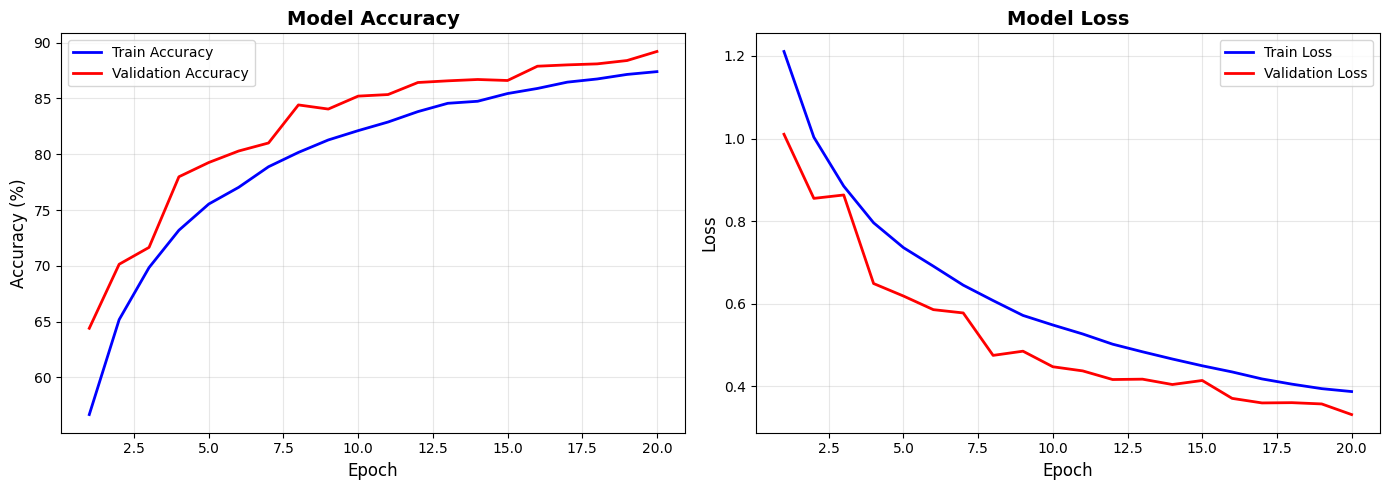

In [11]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Accuracy plot
    ax1.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    ax1.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax2.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


## Model Evaluation


In [12]:
# Load best model
model.load_state_dict(torch.load('vgg13_cifar10_best.pth'))
model.eval()

# Evaluate on test set
correct = 0
total = 0
all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = 100. * correct / total
print(f"\n{'='*50}")
print(f"Test Accuracy: {accuracy:.4f}% ({correct}/{total})")
print(f"{'='*50}\n")


C:\Users\NortonFire\AppData\Local\Temp\ipykernel_21696\682091713.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg13_cifar10_best.pth


Test Accuracy: 89.2100% (8921/10000)



In [13]:
# Classification report
print("Classification Report:")
print("="*70)
print(classification_report(all_labels, all_predictions, 
                          target_names=class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

    airplane     0.8998    0.8890    0.8944      1000
  automobile     0.9505    0.9610    0.9557      1000
        bird     0.8541    0.8370    0.8455      1000
         cat     0.8201    0.7520    0.7846      1000
        deer     0.8919    0.8830    0.8874      1000
         dog     0.8282    0.8390    0.8336      1000
        frog     0.8874    0.9540    0.9195      1000
       horse     0.9262    0.9160    0.9211      1000
        ship     0.9205    0.9490    0.9345      1000
       truck     0.9354    0.9410    0.9382      1000

    accuracy                         0.8921     10000
   macro avg     0.8914    0.8921    0.8914     10000
weighted avg     0.8914    0.8921    0.8914     10000



## Confusion Matrix


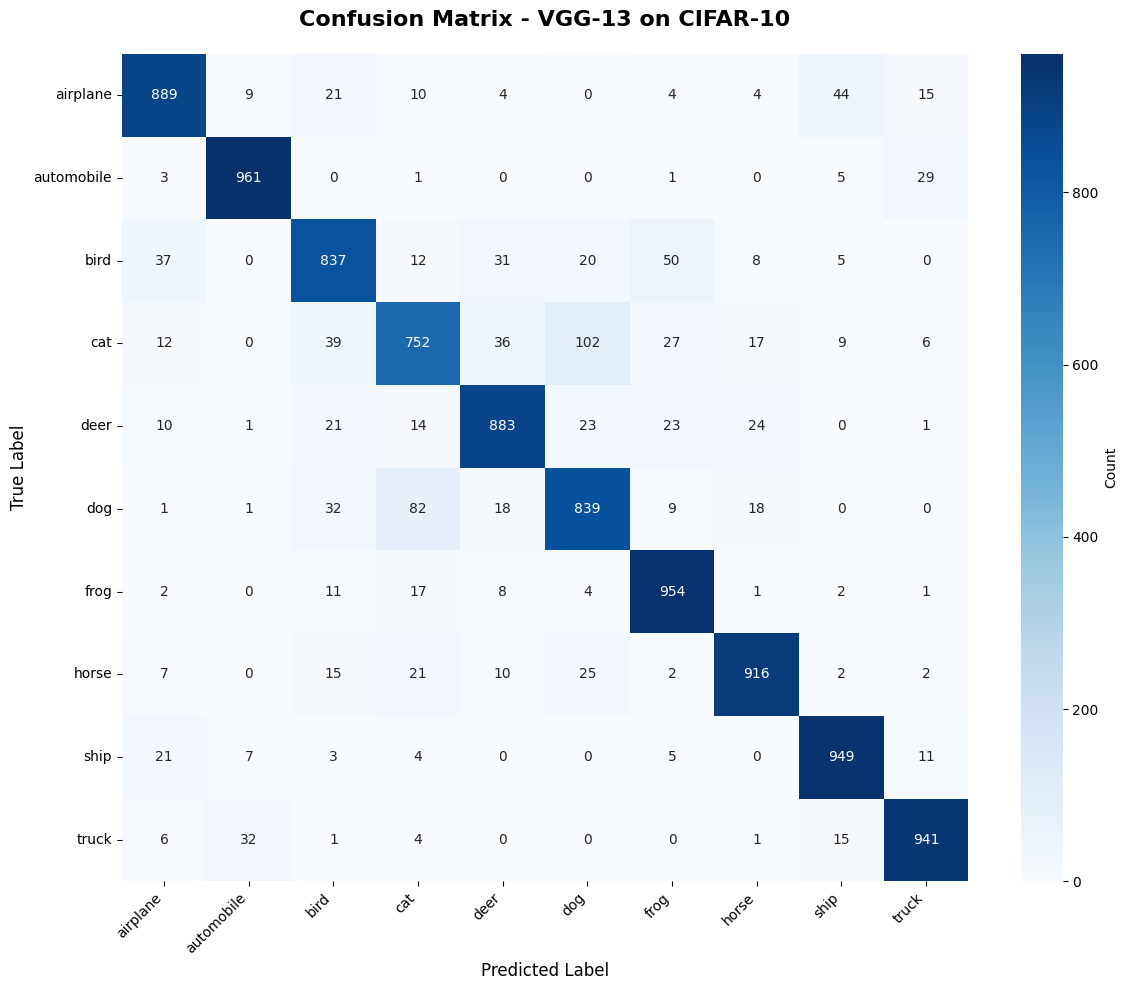

In [14]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - VGG-13 on CIFAR-10', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(all_labels, all_predictions, class_names)


## Predictions Visualization


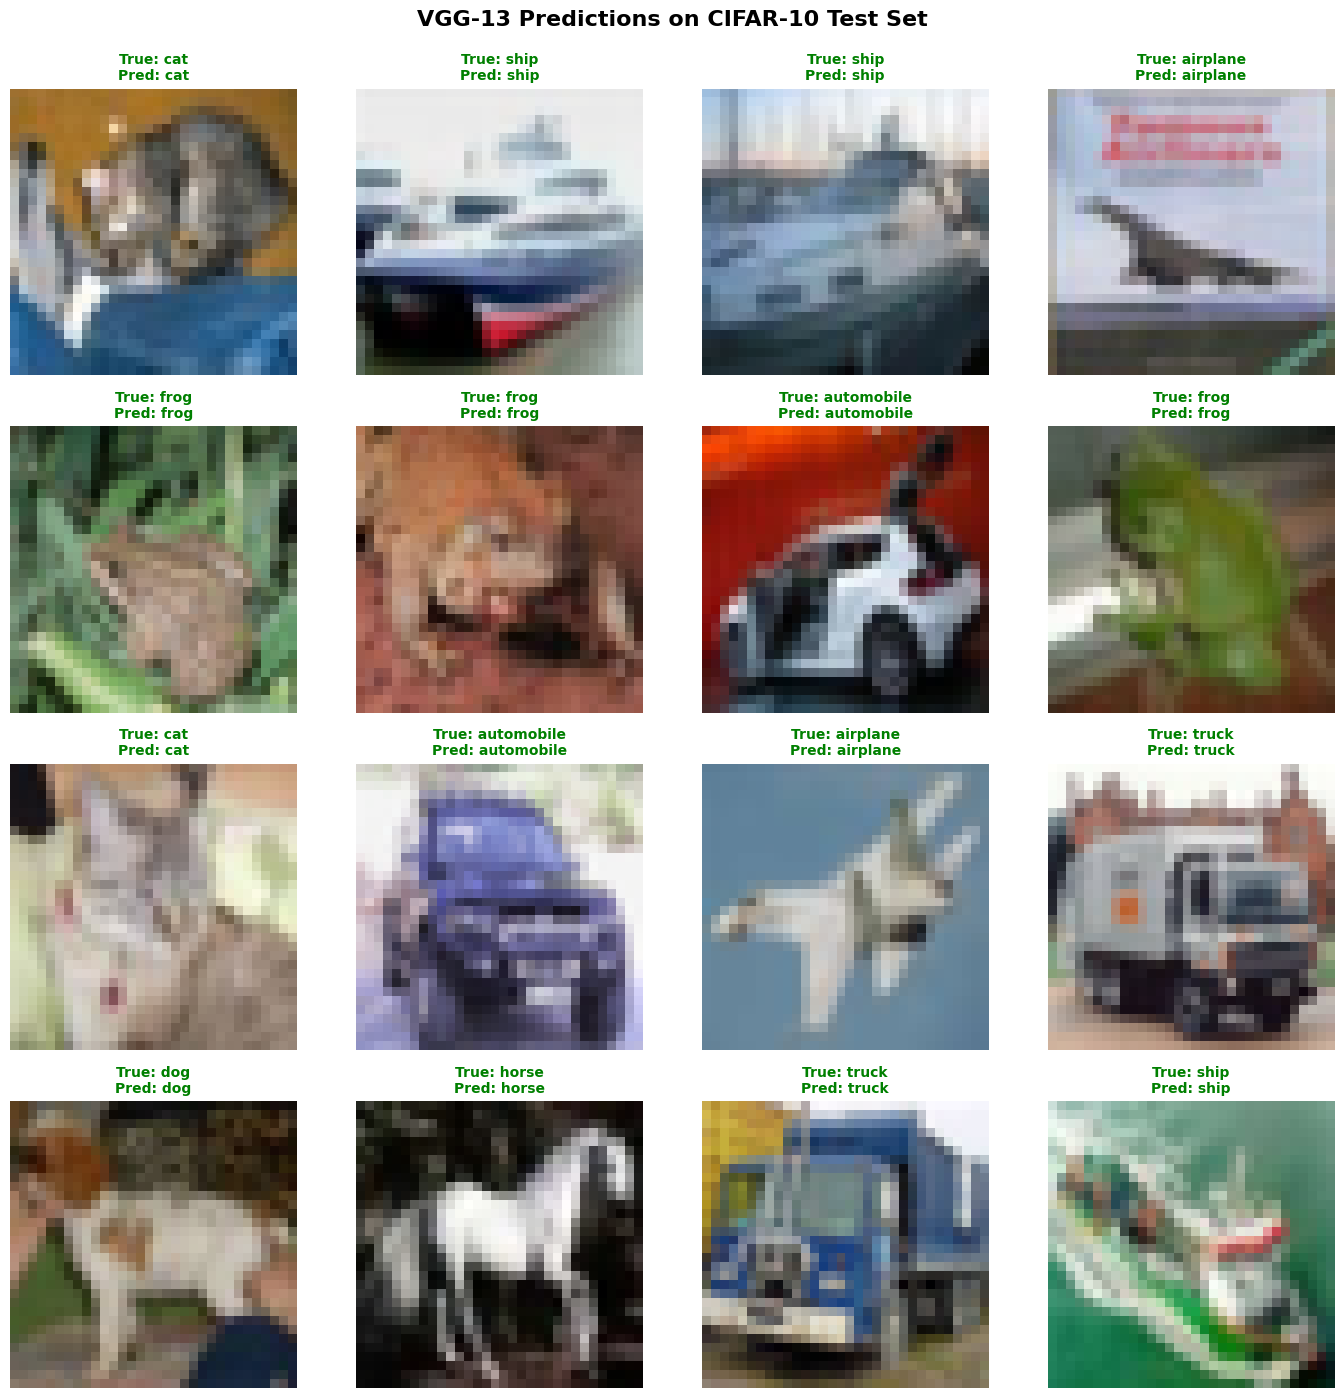

In [15]:
# Get some test images for visualization
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Denormalize images for display
def denormalize(tensor):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

images_denorm = denormalize(images).cpu()

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.ravel()

for i in range(16):
    img = images_denorm[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].axis('off')
    
    true_label = class_names[labels[i].item()]
    pred_label = class_names[predicted[i].item()]
    
    # Color: green if correct, red if incorrect
    color = 'green' if labels[i] == predicted[i] else 'red'
    
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}',
                     fontsize=10, color=color, fontweight='bold')

plt.suptitle('VGG-13 Predictions on CIFAR-10 Test Set', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Per-Class Accuracy Analysis


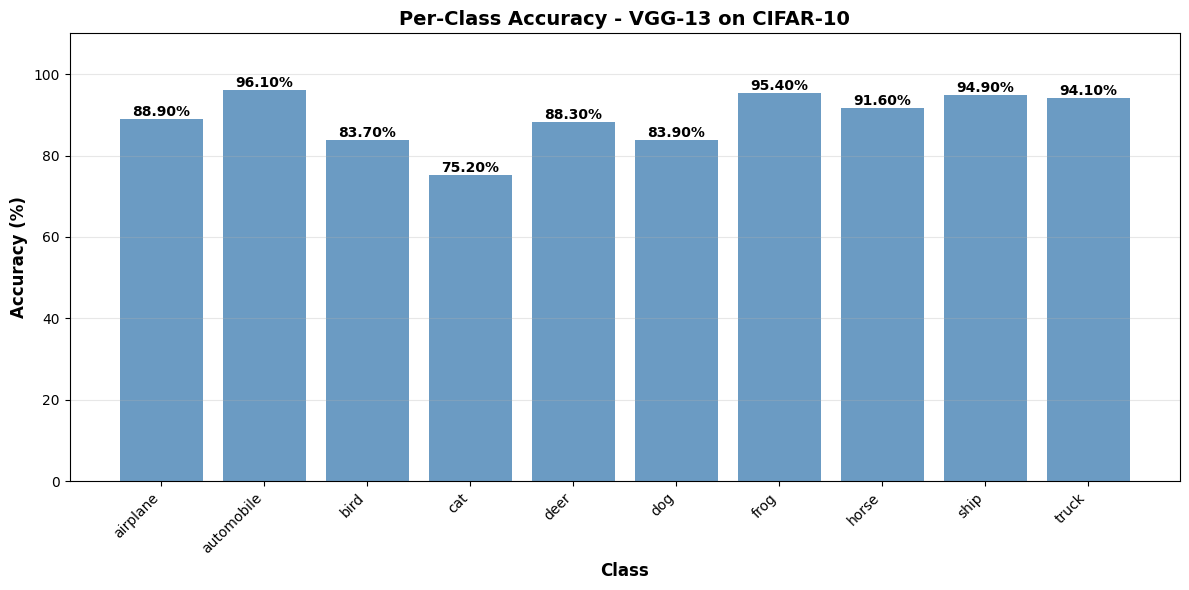


Per-Class Accuracy Summary:
airplane    : 88.90%
automobile  : 96.10%
bird        : 83.70%
cat         : 75.20%
deer        : 88.30%
dog         : 83.90%
frog        : 95.40%
horse       : 91.60%
ship        : 94.90%
truck       : 94.10%
Mean Accuracy: 89.21%


In [16]:
# Calculate per-class accuracy
def plot_per_class_accuracy(y_true, y_pred, class_names):
    """Plot accuracy for each class."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    class_accuracies = []
    
    for i in range(len(class_names)):
        class_mask = y_true == i
        class_correct = np.sum((y_true[class_mask] == y_pred[class_mask]))
        class_total = np.sum(class_mask)
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        class_accuracies.append(class_accuracy * 100)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(class_names)), class_accuracies, color='steelblue', alpha=0.8)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, class_accuracies)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.2f}%',
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class Accuracy - VGG-13 on CIFAR-10', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim([0, 110])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nPer-Class Accuracy Summary:")
    print("="*50)
    for name, acc in zip(class_names, class_accuracies):
        print(f"{name:12s}: {acc:.2f}%")
    print("="*50)
    print(f"Mean Accuracy: {np.mean(class_accuracies):.2f}%")

plot_per_class_accuracy(all_labels, all_predictions, class_names)


## Model Summary


In [17]:
print("="*70)
print("VGG-13 MODEL SUMMARY")
print("="*70)
print(f"Architecture: VGG-13 (10 Conv + 3 FC layers)")
print(f"Dataset: CIFAR-10")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Device: {device}")
print(f"Best Test Accuracy: {accuracy:.2f}%")
print("="*70)


VGG-13 MODEL SUMMARY
Architecture: VGG-13 (10 Conv + 3 FC layers)
Dataset: CIFAR-10
Total Parameters: 9,943,370
Device: cuda
Best Test Accuracy: 89.21%
